In [133]:
from yolact import Yolact
from data import cfg, set_cfg, COLORS
from utils.augmentations import FastBaseTransform
from layers.output_utils import postprocess

import torch
import torch.backends.cudnn as cudnn
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
from IPython import display
from collections import defaultdict
import time
from math import sqrt

In [149]:
## Some helper functions


def evalframe(net, frame):
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)

    return preds

def class_colour(x):
    colours = ['red', 'green', 'blue', 'cyan', 'yellow', 'lime', 'purple', 'orange','slategrey','magenta']
    return colours[x%(len(colours))]

def drawPoints(image, points, colours, size):  #Draw a set of (x,y) points on a PIL image
    draw = ImageDraw.Draw(image, 'RGBA')
    
    for i in range(0, len(points)):
        x0 = points[i][0] - size/2
        x1 = points[i][0] + size/2
        y0 = points[i][1] - size/2
        y1 = points[i][1] + size/2
        draw.ellipse([x0,y0,x1,y1], fill=colours[i])
        
    return image

def drawBBoxes(image, boxes, colours, linewidth):  #Draw a set of boxes on a pil image
    draw = ImageDraw.Draw(image, 'RGBA')
    
    for i in range(0, len(boxes)):
        draw.rectangle(boxes[i], outline=colours[i], width=linewidth)
    
    return image

def drawMasks(image, masks, colours, alpha):
    draw = ImageDraw.Draw(image, 'RGBA')
    for i in range(masks.shape[0]):
        mask = masks[i].astype('uint8')
        #verts = convex_hull_image(mask)
        conts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        verts = [conts[1][0][i][0].tolist() for i in range(len(conts[1][0]))]
        verts = [(i[0], i[1]) for i in verts]
        (r,g,b) = ImageColor.getrgb(colours[i])
        draw.polygon(verts, fill=(r,g,b,alpha))
    
    return image

    
def drawSandwichStats(image, sandwich_stats, colours):
    draw = ImageDraw.Draw(image, 'RGB')
    
    
        

In [4]:
# an abridged version from prep_display eval.py for drawing masks
color_cache = defaultdict(lambda: {})
def draw_masks(classes, scores, boxes, masks, img, class_color=False, draw_classnames=True, draw_scores=True, mask_alpha=0.45, fps_str=''):
    """
    Note: If undo_transform=False then im_h and im_w are allowed to be None.
    """ 
    img_gpu = img / 255.0
    h, w, _ = img.shape

    #classes = classes.cpu().numpy()
    scores = scores.cpu().numpy()
    boxes = boxes.cpu().numpy()

    num_dets_to_consider = classes.shape[0]

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)

        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            # The image might come in as RGB or BRG, depending
            color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice

    # After this, mask is of size [num_dets, h, w, 1]
    masks = masks[:num_dets_to_consider, :, :, None]

    # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
    colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
    masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

    # This is 1 everywhere except for 1-mask_alpha where the mask is
    inv_alph_masks = masks * (-mask_alpha) + 1

    # I did the math for this on pen and paper. This whole block should be equivalent to:
    #    for j in range(num_dets_to_consider):
    #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
    masks_color_summand = masks_color[0]
    if num_dets_to_consider > 1:
        inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
        masks_color_cumul = masks_color[1:] * inv_alph_cumul
        masks_color_summand += masks_color_cumul.sum(dim=0)

    img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand



    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    if num_dets_to_consider == 0:
        return img_numpy

    for j in reversed(range(num_dets_to_consider)):
        x1, y1, x2, y2 = boxes[j, :]
        color = get_color(j)
        score = scores[j]

        if draw_classnames:
            cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)

            _class = cfg.dataset.class_names[classes[j]]
            text_str = '%s: %.2f' % (_class, score) if draw_scores else _class

            font_face = cv2.FONT_HERSHEY_DUPLEX
            font_scale = 0.6
            font_thickness = 1

            text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

            text_pt = (x1, y1 - 3)
            text_color = [255, 255, 255]

            cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
            cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)


    return img_numpy

In [5]:
#  Setup the YOLACT model for inference

set_cfg('yolact_plus_resnet50_config')  # Set config
torch.set_default_tensor_type('torch.cuda.FloatTensor')  # Setup pytorch cuda
cudnn.fastest = True
dataset = None  # Set dataset none

net = Yolact()
net.load_weights('weights/yolact_plus_resnet50_112_28800.pth')
net.eval()  # set to evaluation mode
net.cuda()  # use cuda

net.detect.use_fast_nms = True
net.detect.use_cross_class_nms = False
cfg.mask_proto_debug = False





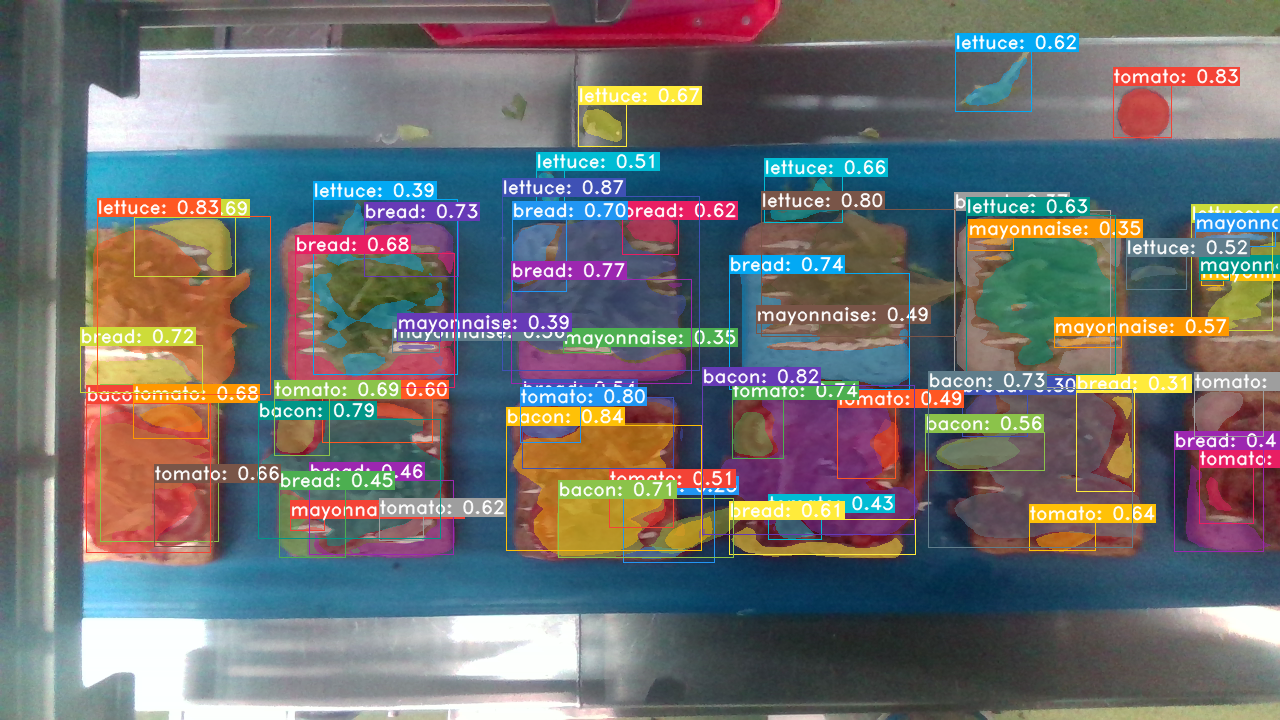

In [6]:
## Run inference on the specifed image and draw the raw output

path = '../images_00/0796.png' #0791 has connected region example
image = cv2.imread(path)
def inference_cv2_img(image):
    h, w, _ = image.shape
    frame = torch.from_numpy(image).cuda().float()
    preds = evalframe(net, frame)
    save = cfg.rescore_bbox
    cfg.rescore_bbox = True
    classes, scores, boxes, masks = postprocess(preds, w, h, score_threshold=0.5)
    cfg.rescore_bbox = save

    return frame, classes, scores, boxes, masks

frame, classes, scores, boxes, masks = inference_cv2_img(image)

img = draw_masks(classes, scores, boxes, masks, frame)
img = img[:, :, (2, 1, 0)] #Transform from cv2's bgr to rgb
pilimg = Image.fromarray(img, 'RGB')
display.display(pilimg)

In [7]:
## Generate a detections array for easy manipulation

def generate_detections_dict(boxes, classes, masks, scores):
    boxes_cpu = boxes.cpu()
    classes_cpu = classes.cpu().numpy().tolist()
    masks_cpu = masks.cpu()
    scores_cpu = scores.cpu().numpy().tolist()

    detections = []
    for i in range(0,boxes_cpu.shape[0]):
        box = boxes_cpu[i]
        det = {'box' : box,
               'box_centre' : ((box[0] + box[2])/2, (box[1]+box[3])/2),
               'mask' : masks_cpu[i].detach(),
               'class' : classes_cpu[i],
               'score' : scores_cpu[i]}
        detections.append(det)

    return detections

detections = generate_detections_dict(boxes, classes, masks, scores)

## Sandwich Identification

Sandwich identification uses traditional CV techniques to identify individual sandwiches on the production line. We makes the following assumptions:
- Sandwiches are presented on a background that can be thresholded
- Sandiwches generally are of a regular size/shape

Identification uses the following steps
1. Threshold the colour of the conveyor belt
2. Apply a safe area to only focus on the central sandwiches
3. Apply a morpological closure to the image to generate distinct sandiwch regions
4. Run connected components to determine unique regions in the image
5. Split any regions that are not roughly square, to combat ingredients occulding the conveyor
6. Assign detections from the IS model by inspecting the midpoint of the detection to determine if it falls within a sandwich region

region 2 too tall, splitting to create new region
region 4 too tall, splitting to create new region


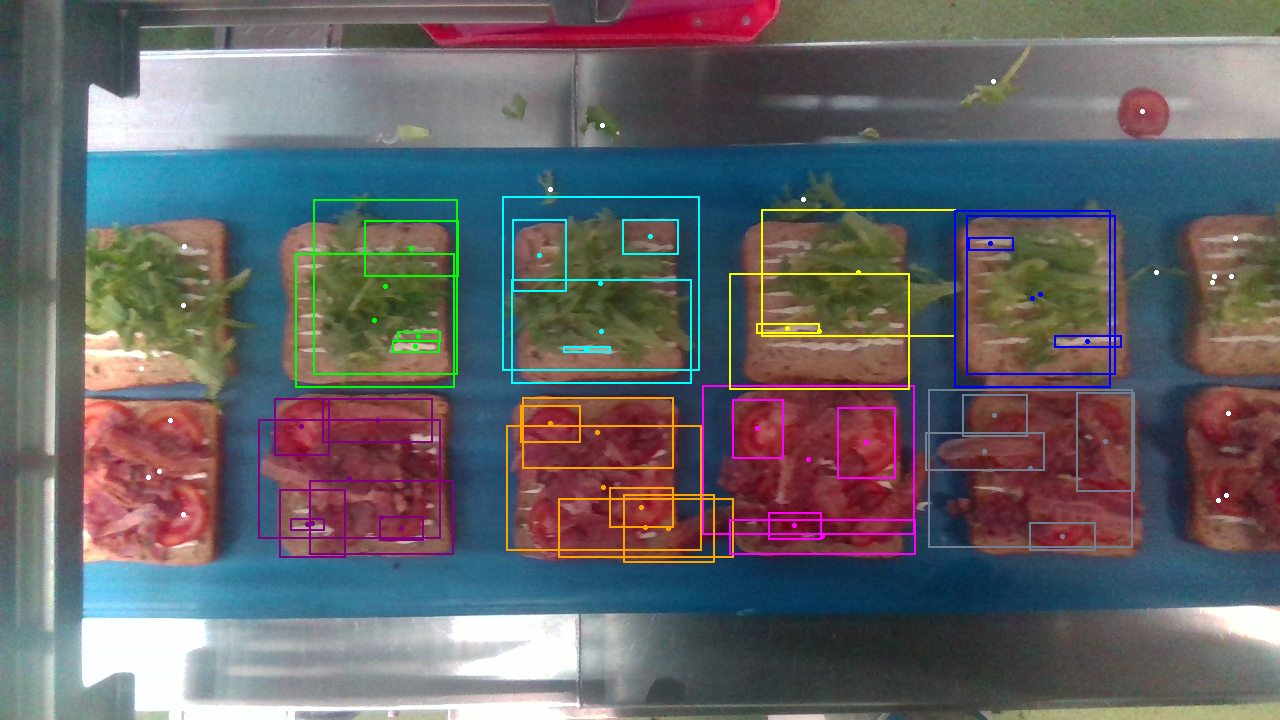

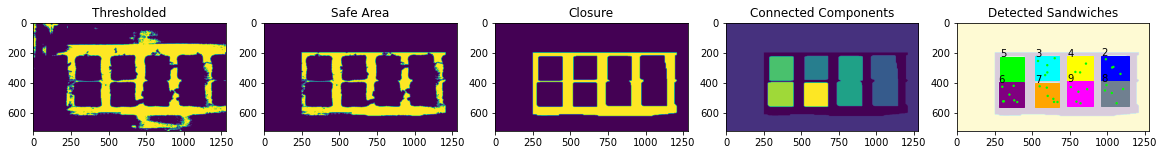

In [153]:
#Thresholding to remove blue belt BG
upperBlue = np.array([230, 130, 60])
lowerBlue = np.array([50, 25, 0])
mask_thresh = cv2.inRange(image, lowerBlue, upperBlue)

#Mask out edges of image
def maskEdges(img, top, bottom, left, right):
    new_img = np.copy(img) #Make a copy so we can visualise before and after
    new_img[0:top] = 0 #Top margin
    new_img[-bottom:] = 0 #Bottom margin
    new_img[:, 0:left] = 0 #Left margin
    new_img[:, -right:] = 0 #Right Margin
    return new_img
mask_safe = maskEdges(mask_thresh, 200, 100, 250, 75)

#Closing on image to extract sandwich regions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(120,120))
mask_closed = cv2.morphologyEx(mask_safe, cv2.MORPH_CLOSE, kernel)

#Connected Components
mask_inverted = cv2.bitwise_not(mask_closed)
numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_inverted, 4)
   

#  Deal with connected sandwiches eg: ../images_00/0791.png
#  In general, the sandwich regions should be square, but if the belt is occuluded
#      by an ingredient then the sandiwch region might connnect with a neighbour
#      this would make the region roughly twice as wide or tall
for i in range(2, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    
    err_pc = 0.7 #Look for regions that not square by some given percentage margin of error
    
    if h > w*(1+err_pc):
        print('region {} too tall, splitting to create new region'.format(i))
        #create new region
        new_y = y+(h/2)
        new_h = h/2
        stats = np.append(stats, [[x, new_y, w, new_h, w*new_h]], axis=0)
        
        numLabels += 1 #Update number of regions
        
        #update current region
        stats[i, cv2.CC_STAT_HEIGHT] = new_h
        
    if w > h*(1+err_pc):
        print('region {} too wide, splitting to create new region'.format(i))
        new_x = x+(w/2)
        new_w = w/2
        stats = np.append(stats, [[new_x, y, new_w, h, new_w*h]], axis=0)
        
        numLabels += 1 #Update number of regions
        
        #update current region
        stats[i, cv2.CC_STAT_WIDTH] = new_w


def sandwichLabelling(img, err_pc = 0.7): #Look for regions that not square by some given percentage margin of error
    numLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, 4)
    
    #Delete region 0 & 1 (background & safe area), sandwiches labelled from 1
    numLabels -= 2
    labels[labels==1] = 0
    stats = np.delete(stats, [0,1], 0)
    centroids = np.delete(centroids, [0,1], 0)
    
    for i in range(numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        if h > w*(1+err_pc):
            print('region {} too tall, splitting to create new region'.format(i+1))
            #create new region
            new_y = int(y+(h/2))
            new_h = int(h/2)
            stats = np.append(stats, [[x, new_y, w, new_h, w*new_h]], axis=0)
            new_cent_x = x + w/2
            new_cent_y = new_y + new_h/2
            centroids = np.append(centroids, [[new_cent_x, new_cent_y]], axis=0)

            numLabels += 1 #Update number of regions

            #update current region
            labels[new_y:new_y+new_h, x:x+w] = numLabels #kind of messy way to update this
            stats[i, cv2.CC_STAT_HEIGHT] = new_h
            centroids[i, 1] = y + new_h/2
            
            
        if w > h*(1+err_pc):
            print('region {} too wide, splitting to create new region'.format(i+1))
            new_x = int(x+(w/2))
            new_w = int(w/2)
            stats = np.append(stats, [[new_x, y, new_w, h, new_w*h]], axis=0)
            new_cent_x = new_x + new_w/2
            new_cent_y = y + h/2
            centroids = np.append(centroids, [[new_cent_x, new_cent_y]], axis=0)

            numLabels += 1 #Update number of regions

            #update current region
            labels[y:y+h, new_x:new_x+new_w] = numLabels
            stats[i, cv2.CC_STAT_WIDTH] = new_w
            centroids[i, 0] = x + new_w/2

    return numLabels, labels, stats, centroids


#Ignore detections outside of sandwich boxes
for i in range(len(detections)):
    bbox_c = detections[i]['box_centre']
    sandwich_id = None
    for j in range(2, numLabels):
        x = stats[j, cv2.CC_STAT_LEFT]
        y = stats[j, cv2.CC_STAT_TOP]
        w = stats[j, cv2.CC_STAT_WIDTH]
        h = stats[j, cv2.CC_STAT_HEIGHT]
        
        if bbox_c[0] >= x and bbox_c[0] <= x+w and bbox_c[1] >= y and bbox_c[1] <= y+h:
            sandwich_id = j
    detections[i]['sandwich_id'] = sandwich_id

#Show result

pilimg = Image.open(path)
pilimg = pilimg.convert(mode='RGB')

colours = [class_colour(i['sandwich_id']) for i in detections if i['sandwich_id'] is not None]
points = [i['box_centre'] for i in detections if i['sandwich_id'] is not None]
pilimg = drawPoints(pilimg, points, colours, 4)

boxes_sandwich = [i['box'].numpy().tolist() for i in detections if i['sandwich_id'] is not None]
pilimg = drawBBoxes(pilimg, boxes_sandwich, colours, 2)


points = [i['box_centre'] for i in detections if i['sandwich_id'] is None]
colours = ['white' for i in detections if i['sandwich_id'] is None]
pilimg = drawPoints(pilimg, points, colours, 4)

display.display(pilimg)


#  Show sandwich segmentation

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5)
fig.set_figwidth(20)

ax1.set_title("Thresholded")
ax1.imshow(mask_thresh)
ax2.set_title("Safe Area")
ax2.imshow(mask_safe)
ax3.set_title("Closure")
ax3.imshow(mask_closed)
ax4.set_title("Connected Components")
ax4.imshow(labels)
ax5.set_title("Detected Sandwiches")
ax5.imshow(mask_inverted, alpha=0.2)

for i in range(2, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    rect = patches.Rectangle((x,y), w, h, linewidth=1, edgecolor=class_colour(i), facecolor=class_colour(i))
    ax5.add_patch(rect)
    ax5.text(x, y, str(i))
for i in range(len(boxes_sandwich)):
    box = boxes_sandwich[i]
    col = class_colour(classes[i])
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor=col, facecolor='none')
    point = patches.Circle(((box[0]+box[2])/2, (box[1]+box[3])/2),8, facecolor='lime')
    #ax5.add_patch(rect)
    ax5.add_patch(point)

In [9]:
## Ingredient coverage stats


#sandwich_stats = defaultdict(lambda: {})

# fig, axs = plt.subplots(1,numLabels-2)

## Get an area mask for the sandwich, as a base area
# for i in range(2, numLabels):
#     sandwich_area = np.zeros(image.shape)
#     #sandwich_area[sandwich_area!=i] = 0
    
#     x = int(stats[i, cv2.CC_STAT_LEFT])
#     y = int(stats[i, cv2.CC_STAT_TOP])
#     w = int(stats[i, cv2.CC_STAT_WIDTH])
#     h = int(stats[i, cv2.CC_STAT_HEIGHT])
    
#     sandwich_area[y:y+h, x:x+w] = 1
    
#     sandwich_stats[i]['area_mask'] = sandwich_area

# for i in range(0, numLabels-2):
#     axs[i].imshow(sandwich_stats[i+2]['area_mask'])


sandwich_stats = [{} for i in range(numLabels)]

for i in sandwich_stats:
    for j in cfg.dataset.class_names:
        i[j] = {'area' : 0,
                'count' : 0}
    

for i in detections:
    s_id = i['sandwich_id']
    if s_id is not None:
        _class = cfg.dataset.class_names[i['class']]
        area = torch.sum(i['mask']).item()

        sandwich_stats[s_id][_class]['area'] += area
        sandwich_stats[s_id][_class]['count'] += 1
    

for i in sandwich_stats:
    t_area = 0
    for j in i:
        t_area += i[j]['area']
    
    for j in i:
        i[j]['pc_area'] = i[j]['area']/t_area if t_area > 0 else 0
    

for i in range(2, len(sandwich_stats)):
    stat = sandwich_stats[i]
    print("Sandwich ID: {}".format(i))
    print("        Tomato: {}  {:.1f}".format(stat['tomato']['count'],stat['tomato']['pc_area']*100))
    print("         Bread: {}  {:.1f}".format(stat['bread']['count'],stat['bread']['pc_area']*100))
    print("       Lettuce: {}  {:.1f}".format(stat['lettuce']['count'],stat['lettuce']['pc_area']*100))
    print("         Bacon: {}  {:.1f}".format(stat['bacon']['count'],stat['bacon']['pc_area']*100))
    print("    Mayonnaise: {}  {:.1f}".format(stat['mayonnaise']['count'],stat['mayonnaise']['pc_area']*100))
    print()

Sandwich ID: 2
        Tomato: 0  0.0
         Bread: 1  37.3
       Lettuce: 1  60.0
         Bacon: 0  0.0
    Mayonnaise: 2  2.7

Sandwich ID: 3
        Tomato: 0  0.0
         Bread: 3  30.4
       Lettuce: 1  69.5
         Bacon: 0  0.0
    Mayonnaise: 1  0.1

Sandwich ID: 4
        Tomato: 0  0.0
         Bread: 1  38.9
       Lettuce: 1  59.6
         Bacon: 0  0.0
    Mayonnaise: 1  1.5

Sandwich ID: 5
        Tomato: 0  0.0
         Bread: 2  59.1
       Lettuce: 1  38.2
         Bacon: 0  0.0
    Mayonnaise: 2  2.7

Sandwich ID: 6
        Tomato: 3  15.4
         Bread: 2  18.9
       Lettuce: 0  0.0
         Bacon: 1  65.4
    Mayonnaise: 1  0.3

Sandwich ID: 7
        Tomato: 2  6.9
         Bread: 2  7.6
       Lettuce: 0  0.0
         Bacon: 2  85.5
    Mayonnaise: 0  0.0

Sandwich ID: 8
        Tomato: 1  3.1
         Bread: 2  7.6
       Lettuce: 0  0.0
         Bacon: 2  89.3
    Mayonnaise: 0  0.0

Sandwich ID: 9
        Tomato: 3  11.7
         Bread: 1  8.9
       L

## Multi-Frame Sandwich Detection

region 3 too tall, splitting to create new region
region 2 too tall, splitting to create new region
region 3 too tall, splitting to create new region
region 1 too tall, splitting to create new region
region 3 too tall, splitting to create new region


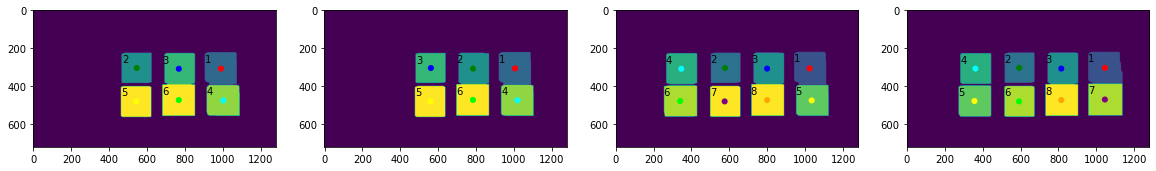

In [225]:
## Run inference on a list of frames

#Set the list of frames
path_prefix = '../images_00/'
frame_paths = ['0792.png', '0793.png', '0794.png', '0795.png'] # Sandwiches enter frame example
#frame_paths = ['0798.png', '0798.png', '0799.png', '0800.png'] # sandwiches leave frame example
images = [cv2.imread(path_prefix+i) for i in frame_paths]

#Run inference on each frame
frames, frame_classes, frame_scores, frame_boxes, frame_masks = [],[],[],[],[]
for i in images:
    frame, classes, scores, boxes, masks = inference_cv2_img(i)
    frames.append(frame)
    frame_classes.append(classes)
    frame_scores.append(scores)
    frame_boxes.append(boxes)
    frame_masks.append(masks)

#Generate the detections dict on each frame
frame_detections = []
for i in range(len(frames)):
    frame_detections.append(generate_detections_dict(frame_boxes[i], 
                                                     frame_classes[i], frame_masks[i], frame_scores[i]))
    
#Run sandwich detection on each frame
#Thresholding to remove blue belt BG
upperBlue = np.array([230, 130, 60])
lowerBlue = np.array([50, 25, 0])
thresh_frames = [cv2.inRange(img, lowerBlue, upperBlue) for img in images]

#Mask out edges of image
safe_frames = [maskEdges(img, 200, 100, 250, 75) for img in thresh_frames]

#Closing on image to extract sandwich regions
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(120,120))
closed_frames = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in safe_frames]

#Connected Components
inverted_frames = [cv2.bitwise_not(img) for img in closed_frames]
cc_frames = [sandwichLabelling(img) for img in inverted_frames]


fig, axs = plt.subplots(1,len(cc_frames))
fig.set_figwidth(20)

for i, x in enumerate(cc_frames):
    axs[i].imshow(x[1])
    stats = x[2]
    numLabels = x[0]
    for j in range(numLabels):
        x = stats[j, cv2.CC_STAT_LEFT]
        y = stats[j, cv2.CC_STAT_TOP]
        w = stats[j, cv2.CC_STAT_WIDTH]
        h = stats[j, cv2.CC_STAT_HEIGHT]
        cent_x = int(x + w/2)
        cent_y = int(y + h/2)
        point = patches.Circle((cent_x, cent_y),16, facecolor=class_colour(j))
        axs[i].add_patch(point)
        axs[i].text(x, y+50, str(j+1))

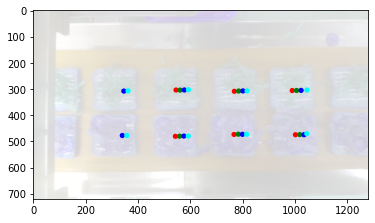

In [226]:
#Visualise moving centroids, (each frame has different colour, starting at red)
fig, ax = plt.subplots(1)

ax.imshow(images[0], alpha=0.2)
for idx, frame in enumerate(cc_frames):
    cents = frame[3]
    for c in cents:
        point = patches.Circle((c[0], c[1]),10, facecolor=class_colour(idx))
        ax.add_patch(point)

For each centroid in frame n+1, match it with the closest centroid in n. Paired centroids that are close together are the same sandwich, if the distance is high then they are new sandwiches. 

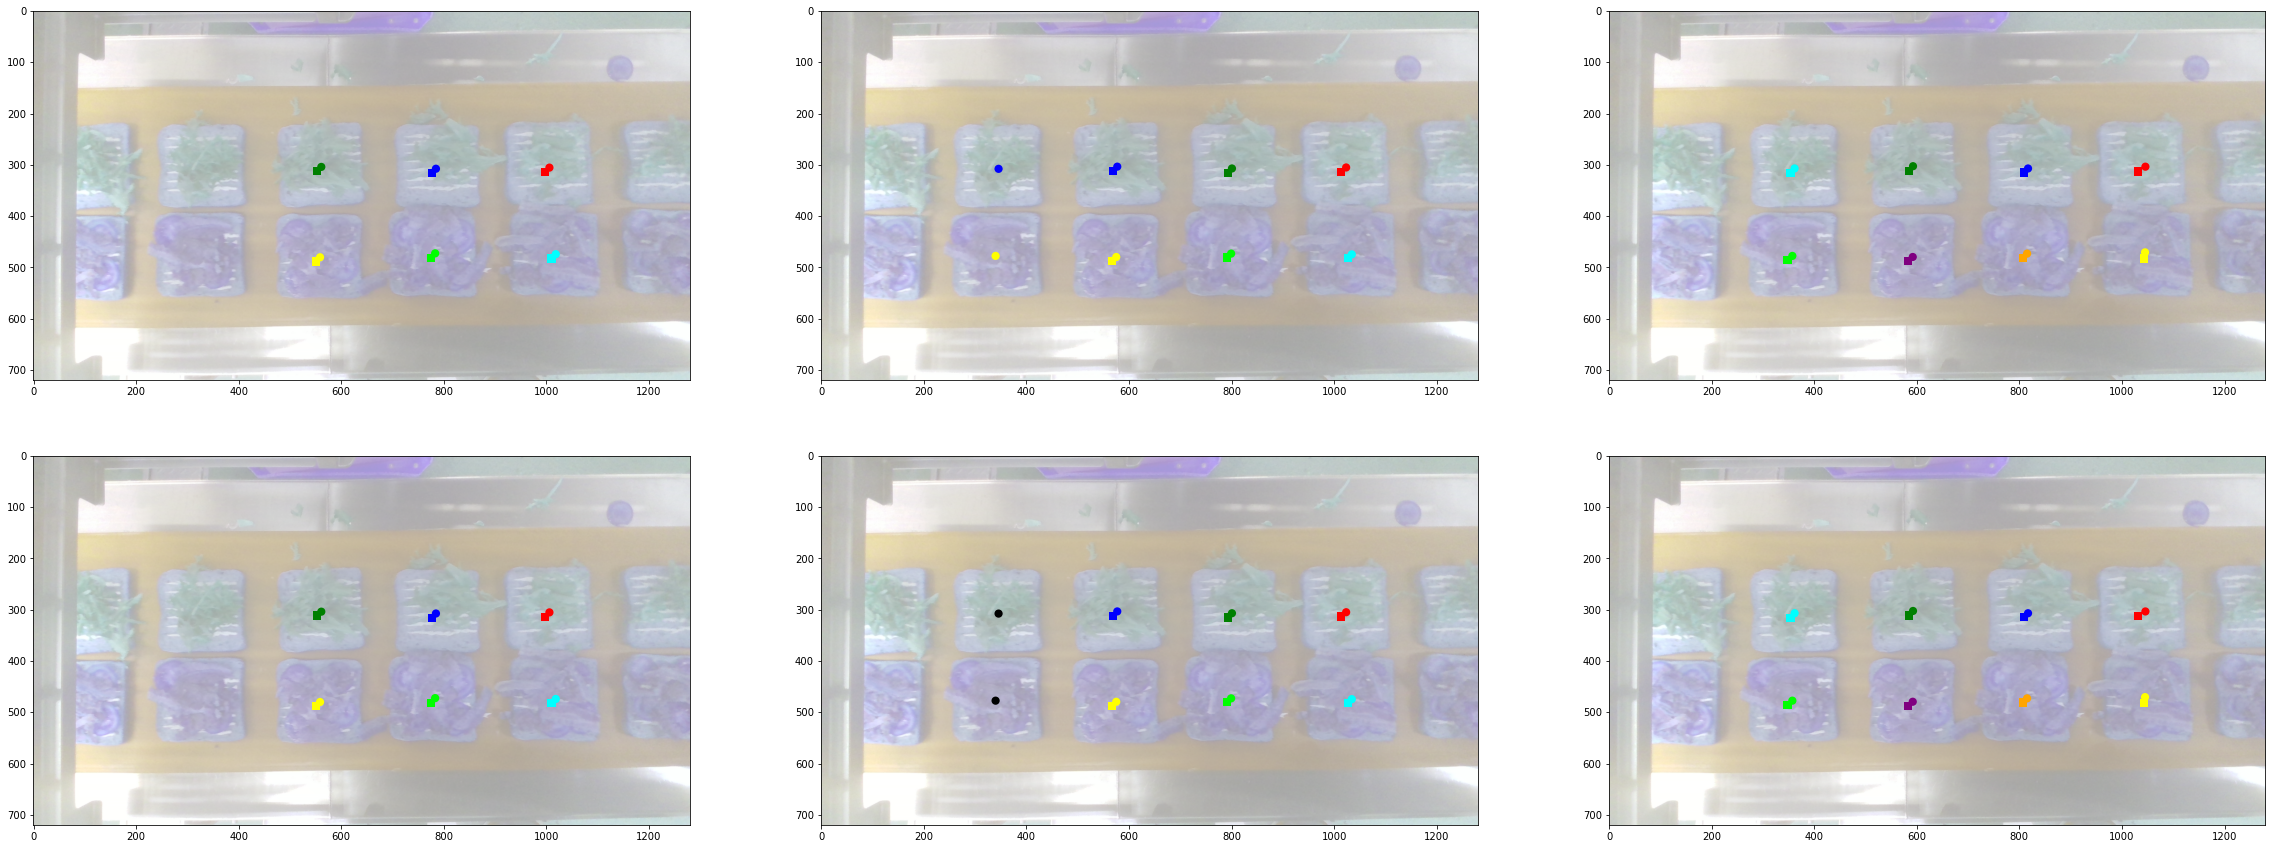

In [229]:
fig, axs = plt.subplots(2, len(cc_frames)-1)
fig.set_figwidth(40)
fig.set_figheight(15)

next_label = cc_frames[0][0]+1 #The id for the next sandwich to appear in frame

#initialise the global sandwich IDs as the local ids in each frame
sandwich_ids_frame_mapping = [[j for j in range(1,i[0]+1)] for i in cc_frames]

#Compute closest centroids and update sandiwich IDs
#Start with second frame
for i in range(1, len(cc_frames)):
    curr_cents = cc_frames[i][3].tolist()
    prev_cents = cc_frames[i-1][3].tolist()
    
    axs[0][i-1].imshow(images[i], alpha=0.4) #Top row - closest centroid
    axs[1][i-1].imshow(images[i], alpha=0.4) #Top row - closest centroid with average frame movement threshold
    p_c_squares = [patches.Rectangle(c,16,16, facecolor=class_colour(idx)) for idx, c in enumerate(prev_cents)]
    for p in p_c_squares: axs[0][i-1].add_patch(p)
    p_c_squares = [patches.Rectangle(c,16,16, facecolor=class_colour(idx)) for idx, c in enumerate(prev_cents)]
    for p in p_c_squares: axs[1][i-1].add_patch(p)
    
    closest_cent_ids = []
    closest_cent_dists = []
    for c in curr_cents:
        dists = [sqrt((c[0]-c_p[0])**2 + (c[1]-c_p[1])**2) for c_p in prev_cents]
        closest_cent = np.argmin(dists)
        closest_cent_ids.append(closest_cent)
        closest_cent_dists.append(min(dists))
        
        point = patches.Circle(c,8, facecolor=class_colour(closest_cent))
        axs[0][i-1].add_patch(point)
    
    #compute average distance between closest centroids
    avg_frame_movement = 0
    for j in closest_cents: avg_frame_movement += j[1]
    avg_frame_movement /= len(closest_cents)
    
    err_factor = 2.5 #Allow for differences in centroid distances
    
    # When distance greater than average frame movement(+some error), assume the new centroid is a new sandwich
    for idx, dist in enumerate(closest_cent_dists):
        if dist > avg_frame_movement*err_factor:
            sandwich_ids_frame_mapping[i][idx] = next_label
            next_label+=1
            
            point = patches.Circle(curr_cents[idx],8, facecolor='black')
            axs[1][i-1].add_patch(point)
        else:
            sandwich_ids_frame_mapping[i][idx] = sandwich_ids_frame_mapping[i-1][closest_cent_ids[idx]]
            point = patches.Circle(curr_cents[idx],8, facecolor=class_colour(closest_cent_ids[idx]))
            axs[1][i-1].add_patch(point)


 

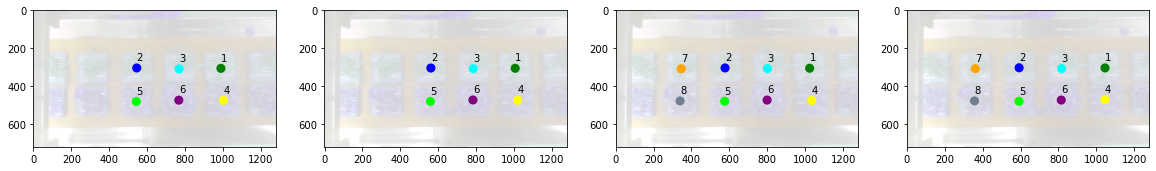

In [230]:
#Show continutity of sandiwch IDs over frames
fig, axs = plt.subplots(1, len(images))
fig.set_figwidth(20)

for i in range(len(images)):
    axs[i].imshow(images[i], alpha=0.2)
    
    for idx, sandwich in enumerate(sandwich_ids_frame_mapping[i]): #idx is local id, sandiwich is global id
        c = cc_frames[i][3][idx]
        point = patches.Circle(c,24, facecolor=class_colour(sandwich))
        axs[i].add_patch(point)
        axs[i].text(c[0], c[1]-40, str(sandwich))
        
        